In [9]:
%matplotlib inline
from fenparsev4 import *
from pybrain.datasets import ClassificationDataSet
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.tools.shortcuts import buildNetwork
from pybrain.structure.modules import TanhLayer
import numpy as np
import random
from sklearn.metrics import confusion_matrix
import os
from __future__ import print_function
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
import pickle

In [12]:
#most important part
def fries_ready():
    os.system('say your fries are done')
    
def write(str):
    sys.stdout.write('\r' + str)
    sys.stdout.flush()
    
def writeln(str):
    sys.stdout.write(str)
    sys.stdout.flush()

num_files = 20
filename_prefix='/media/drive/storage/csv_input/2015-12-08_112mil'
filename_suffix_range=range(1,num_files + 1)
debug=True
    
#read in csv
df = pd.DataFrame()
writeln("Inizializing read of %d files...\n" % (num_files))
for i in filename_suffix_range:
    if debug: write("Reading...%d/%d" % (i, num_files))
    df = df.append(pd.read_csv(filename_prefix + str(i)))
write("Reading...done\n")
#clean columns
df['y'] = df['y'].astype(int)
if debug: writeln("Converting to list...")
df['x'] = df['x'] = df.loc[:, 'x'].apply(lambda x: [1 if '1' == a else 0 for a in x.split(', ')])
length = df.shape[0]
df = df.set_index([range(0,length)])
writeln("done\nShuffling data...")
df = df.reindex(np.random.permutation(df.index))
writeln("done")
write("Splitting data...")
split = df.shape[0] * 4 / 5
all_train = df.iloc[:split, :]
all_test = df.iloc[split:, :]
writeln("done\n")

Inizializing read of 20 files...
Reading...done
Converting to list...done
Splitting data...done


In [13]:
#takes in full dataframe and converts to usable dataset
def build_dataset(all_train, all_test, nb_classes=2, debug=True):
    X_train = list(all_train['x'])
    X_test = list(all_test['x'])
    if debug: print("building y labels")
    y_train = [[1] if y == 1 else [0] for y in all_train['y']]
    Y_test_binary = [1 if y == 1 else 0 for y in all_test['y']]
    if debug: print("converting X_train and X_test to nparrays")
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    if debug: print("converting y labels to categorical")
    # convert class vectors to binary class matrices
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(Y_test_binary, nb_classes)
    return (X_train, Y_train, X_test, Y_test, Y_test_binary)

In [14]:
# y test binary is a binary vector
# Y_test is categorical numpy format
(X_train, Y_train, X_test, Y_test, Y_test_binary) = build_dataset(all_train, all_test)

building y labels
converting X_train and X_test to nparrays
converting y labels to categorical


In [15]:
def getActivation(activation):
    if (activation == 'tanh'):
        return Activation('tanh')
    elif (activation == 'sigmoid'):
        return Activation('sigmoid')
    elif (activation == 'hard_sigmoid'):
        return Activation('hard_sigmoid')
    else:
        print("invalid activation!")

def buildMLP(activation='tanh',depth=3, width=512):
    if depth < 2:
        depth = 2
    model = Sequential()
    model.add(Dense(width, input_shape=(1536,)))
    model.add(getActivation(activation))
    model.add(Dropout(0.2))
    for i in range(0, depth - 2):
        model.add(Dense(width))
        model.add(getActivation(activation))
        model.add(Dropout(0.2))
       
    model.add(Dense(2))
    model.add(Activation('softmax'))

    rms = RMSprop()
    model.compile(loss='categorical_crossentropy', optimizer=rms)
    #print(model.to_json())
    writeln("Model with depth %d built..." % depth)
    return model

def buildRNN(depth=3, width=512):
    if depth < 2:
        depth = 2
    model = Sequential()
    model.add(SimpleRNN(width, input_shape=(1536,)))
    model.add(getActivation(activation))
    model.add(Dropout(0.2))
    for i in range(0, depth - 2):
        model.add(SimpleRNN(width))
        model.add(getActivation(activation))
        model.add(Dropout(0.2))
       
    model.add(Dense(2))
    model.add(Activation('softmax'))

    rms = RMSprop()
    model.compile(loss='categorical_crossentropy', optimizer=rms)
    #print(model.to_json())
    writeln("Model with depth %d built..." % depth)

def buildLSTM(depth=3, width=512):
    if depth < 2:
        depth = 2
    model = Sequential()
    model.add(LSTM(width, input_shape=(1536,)))
    model.add(getActivation(activation))
    model.add(Dropout(0.2))
    for i in range(0, depth - 2):
        model.add(LSTM(width))
        model.add(getActivation(activation))
        model.add(Dropout(0.2))
       
    model.add(Dense(2))
    model.add(Activation('softmax'))

    rms = RMSprop()
    model.compile(loss='categorical_crossentropy', optimizer=rms)
    #print(model.to_json())
    writeln("Model with depth %d built..." % depth)

def buildGRU(depth=3, width=512):
    if depth < 2:
        depth = 2
    model = Sequential()
    model.add(GRU(width, input_shape=(1536,)))
    model.add(getActivation(activation))
    model.add(Dropout(0.2))
    for i in range(0, depth - 2):
        model.add(GRU(width))
        model.add(getActivation(activation))
        model.add(Dropout(0.2))
       
    model.add(Dense(2))
    model.add(Activation('softmax'))

    rms = RMSprop()
    model.compile(loss='categorical_crossentropy', optimizer=rms)
    #print(model.to_json())
    writeln("Model with depth %d built..." % depth)

In [4]:
class KerasExperiment:
    def __init__(self, model, test_df, X_train, Y_train, X_test, Y_test, Y_test_binary, epochs=5, verbose=True):
        self.model = model
        self.test_df = test_df;
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.Y_test_binary = Y_test_binary
        self.nb_epoch = epochs

    #adds specific piece confusion matrices to results dict d
    def add_piece_specifics(self, predicted_y):
        #append column for predicted
        test_df_result = self.test_df.copy()
        test_df_result.loc[:,'predicted'] = predicted_y
        
        #create new row for piece results
        d = {}
        #calculate each piece confusion matrix
        for p in "pPrRnNbBqQkK":
            specific_piece = test_df_result[test_df_result['piece_moved'] == p]
            cm = [confusion_matrix(specific_piece['y'], specific_piece['predicted'])]
            #append column
            d[p + '_cm'] = cm
        #get white and black
        color = test_df_result[test_df_result['piece_moved'].isin(list("PRNBQK"))]
        d["white_cm"] = [confusion_matrix(color['y'], color['predicted'])]
        color = test_df_result[test_df_result['piece_moved'].isin(list("prnbqk"))]
        d["black_cm"] = [confusion_matrix(color['y'], color['predicted'])]
        
        return pd.DataFrame(d, columns = [a + "_cm" for a in "pPrRnNbBqQkK"] + ["white_cm", "black_cm"], index=[1]) 
    
    def run_experiment(self):
        self.model.fit(self.X_train, self.Y_train, nb_epoch=self.nb_epoch,
                  show_accuracy=True, verbose=2,
                  validation_data=(self.X_test, self.Y_test))
        score = self.model.evaluate(self.X_test, self.Y_test,
                               show_accuracy=True, verbose=0)
        predicted_y = self.model.predict_classes(self.X_test, batch_size=32)
        cm_overall = [confusion_matrix(predicted_y, self.Y_test_binary)]
        #create results row 
        results_row = pd.DataFrame({"training_size" : len(self.X_train), \
                                    "test_size" : len(self.Y_test), \
                                      "pct_white" : sum(self.Y_test_binary) * 1.0 / len(self.Y_test_binary), \
                                      "cm_overall": cm_overall, \
                                   "epochs": self.nb_epoch, \
                                   "network" : self.model.to_json()}, index=[1]);
        results_row = results_row.join(self.add_piece_specifics(predicted_y))
        return(results_row)
        
    #    print(confusion_matrix(y_train, out))
        #return pd.DataFrame({"train_size": self.train_df.shape[0], 
#                             "train_white_count" : sum([1 if a.isupper() else 0 for a in self.train_df['piece_moved']]),
#                             "confusion_matrix" : [cm],
#                             "accuracy": [(cm[0][0] + cm[1][1]) * 1.0 / (sum([sum(c) for c in cm]))]})

Model with depth 3 built...

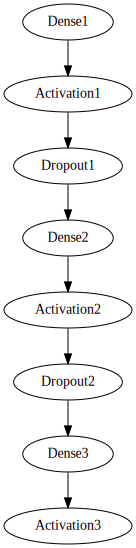

In [21]:
from IPython.display import SVG
from keras.utils.visualize_util import to_graph
model = buildMLP(depth=3)
SVG(to_graph(model).create(prog='dot', format='svg'))

In [18]:
mlp_layers_set = [3]
mlp_width_set = [64, 128, 256, 512, 1024, 2048]
train_size_set = [1000, 10000, 100000, 5000000]
epochs_set = [3, 5, 7]
test_size = 10000

e_list = []
for (mlp_layers, mlp_width, train_size, epoch_selected) in [(a,b,c,d) for a in mlp_layers_set\
                                           for b in mlp_width_set\
                                           for c in train_size_set\
                                           for d in epochs_set]:
    print((mlp_layers, mlp_width, train_size, epoch_selected))
    e = KerasExperiment(buildMLP(depth=mlp_layers, width=mlp_width), all_test.iloc[:test_size,:], X_train[:train_size], Y_train[:train_size],\
                         X_test[:test_size], Y_test[:test_size], Y_test_binary[:test_size], epochs=epoch_selected)
    e_list.append(e)
    

(3, 64, 1000, 3)


Exception: Invalid input shape - Layer expects input ndim=3, was provided with input shape (None, 1536)

In [ ]:
results_df = pd.DataFrame()
count = 0
for e in e_list:
    results_df = results_df.append(e.run_experiment())
    count += 1
    if (count % 5 == 0):
        pickle.dump(results_df, open("2015-12-11-mlpexperiments_results3.p", 'wb'))

In [20]:
json_str = buildMLP(activation='sigmoid', width=5).to_json()
json_str

Model with depth 5 built...

'{"layers": [{"b_constraint": null, "name": "Dense", "activity_regularizer": null, "W_constraint": null, "input_shape": [1536], "init": "glorot_uniform", "activation": "linear", "input_dim": null, "b_regularizer": null, "W_regularizer": null, "output_dim": 512}, {"beta": 0.1, "activation": "sigmoid", "name": "Activation", "target": 0}, {"p": 0.2, "name": "Dropout"}, {"b_constraint": null, "name": "Dense", "activity_regularizer": null, "W_constraint": null, "init": "glorot_uniform", "activation": "linear", "input_dim": null, "b_regularizer": null, "W_regularizer": null, "output_dim": 512}, {"beta": 0.1, "activation": "sigmoid", "name": "Activation", "target": 0}, {"p": 0.2, "name": "Dropout"}, {"b_constraint": null, "name": "Dense", "activity_regularizer": null, "W_constraint": null, "init": "glorot_uniform", "activation": "linear", "input_dim": null, "b_regularizer": null, "W_regularizer": null, "output_dim": 512}, {"beta": 0.1, "activation": "sigmoid", "name": "Activation", "target": 

In [ ]:
json.loads(json_str)['layers'][1]['activation']

In [23]:
#methods to decode serialized network json
import json

def get_num_layers(json_str):
    # number of actual layers - 5 for input and output / 3 for each hidden + 2 for input and output
    return (len(json.loads(json_str)['layers']) - 5) / 3 + 2

def get_first_activation(json_str):
    return json.loads(json_str)['layers'][1]['activation']

def get_first_width(json_str):
    return json.loads(json_str)['layers'][0]['output_dim']


In [24]:
get_first_width(json_str)

512

In [ ]:
results_df.iloc[:, -14:].applymap(lambda x : (x[0][0] + x[1][1]) * 1.0 / sum([sum(a) for a in x]))

In [32]:
results_df.to_csv("2015-12-11-mlpexperiments_results1")

In [36]:
pickle.dump( results_df, open( "2015-12-11-mlpexperiments_results1.p", "wb" ) )

In [ ]:
df = pickle.load( open( "2015-12-11-mlpexperiments_results1.p", "rb" ) )
df.head()

In [38]:
df.columns

Index([u'cm_overall', u'epochs', u'network', u'pct_white', u'test_size',
       u'training_size', u'p_cm', u'P_cm', u'r_cm', u'R_cm', u'n_cm', u'N_cm',
       u'b_cm', u'B_cm', u'q_cm', u'Q_cm', u'k_cm', u'K_cm', u'white_cm',
       u'black_cm'],
      dtype='object')